<a href="https://colab.research.google.com/github/uumami/workshop_riskmathics/blob/main/time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Return Prediction

En este Notebook veremos varios algoritmos de Aprendizaje Supervisado para predecir el precio de las acciones de Microsost usando assets correlacionados y datos historicos.

Utilizaremos datos historicos de Microsoft, y variables independientes que pueden ser assests correlacionados:
* Stocks: IBM (IBM) and Alphabet (GOOGL)
* Currency: USD/JPY and GBP/USD
* Indices: S&P 500, Dow Jones and VIX

Trataremos de predecir los retornos semanales: Mas o menos equivalen a 5 dias de la semana.

# Librerias

In [1]:
!pip install pandas-datareader --upgrade
!pip install yfinance

Requirement already up-to-date: pandas-datareader in /usr/local/lib/python3.7/dist-packages (0.9.0)


In [2]:
#Librerias
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import datetime    

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

#Modelos de Deep Learning
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor

#Librerias Estadisticas
import statsmodels.api as sm

#Salvar y guardar Modelos
from pickle import dump
from pickle import load

# Modelos de Series de Tiempo
from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.tsa.statespace.sarimax import SARIMAX

# Metricas de Error
from sklearn.metrics import mean_squared_error

# Seleccion de Variables
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression


#Graficar 
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Eliminar Warnings

In [3]:
import warnings
warnings.filterwarnings('ignore')

# ETL

In [4]:
import yfinance as yf

In [5]:
stk_tickers = ['MSFT', 'IBM', 'GOOGL']
ccy_tickers = ['DEXJPUS', 'DEXUSUK']
idx_tickers = ['SP500', 'DJIA', 'VIXCLS']
start_date = "2010-01-01"
stocks_df = []
for s in stk_tickers:
    stk_data = yf.Ticker(s)
    stk_data = stk_data.history(start=start_date)
    stk_data.columns = pd.MultiIndex.from_tuples([(c,s) for c in stk_data.columns])
    stocks_df.append(stk_data)
stk_data = pd.concat(stocks_df ,axis=1)

ccy_data = web.DataReader(ccy_tickers, 'fred', start=start_date)
idx_data = web.DataReader(idx_tickers, 'fred', start=start_date)

In [6]:
return_period = 1

Separamos el target y las features.
Creamos la serie de tiempo.

Todas las variables exceptuando MSFT estan laggeadas.  
Ademas tenemos lags de MSFT para 5, 15, 30, y 60 dias.

In [7]:
stk_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Open,High,Low,Close,Volume,Dividends,Stock Splits,Open,High,Low,Close,Volume,Dividends,Stock Splits
,MSFT,MSFT,MSFT,MSFT,MSFT,MSFT,MSFT,IBM,IBM,IBM,IBM,IBM,IBM,IBM,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,23.738725,24.110854,23.715467,23.994564,38409100,0.0,0,90.628851,91.865521,90.400872,91.506264,6155300,0.0,0,313.788788,315.070068,312.432434,313.688690,3908488,0,0.0
2010-01-05,23.917041,24.110858,23.754234,24.002319,49749600,0.0,0,90.974318,91.091776,89.882746,90.400902,6841400,0.0,0,313.903900,314.234222,311.081085,312.307312,6003391,0,0.0
2010-01-06,23.940291,24.095346,23.661196,23.855013,58182400,0.0,0,90.283418,90.843035,89.682361,89.813629,5605300,0.0,0,313.243256,313.243256,303.483490,304.434448,7949443,0,0.0
2010-01-07,23.746469,23.800739,23.405352,23.606922,50559700,0.0,0,89.723790,89.986326,89.060557,89.502716,5840600,0.0,0,305.005005,305.305298,296.621613,297.347351,12815771,0,0.0
2010-01-08,23.475141,23.940302,23.444130,23.769743,51197400,0.0,0,89.171146,90.449258,89.157326,90.400902,4197200,0.0,0,296.296295,301.926941,294.849854,301.311310,9439151,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-02,272.820007,278.000000,272.500000,277.649994,26458000,0.0,0,146.910004,146.949997,139.460007,140.020004,16811200,0.0,0,2463.000000,2508.080078,2461.189941,2505.149902,1299100,0,0.0
2021-07-06,278.029999,279.369995,274.299988,277.660004,31565600,0.0,0,139.990005,140.419998,137.100006,138.779999,8093700,0.0,0,2512.969971,2528.560059,2491.649902,2523.800049,1320200,0,0.0


In [8]:
stk_data.loc[:, ('Close', 'MSFT')]

Date
2010-01-04     23.994564
2010-01-05     24.002319
2010-01-06     23.855013
2010-01-07     23.606922
2010-01-08     23.769743
                 ...    
2021-07-02    277.649994
2021-07-06    277.660004
2021-07-07    279.929993
2021-07-08    277.420013
2021-07-09    277.940002
Name: (Close, MSFT), Length: 2899, dtype: float64

In [9]:
(stk_data.loc[:, ('Close', 'MSFT')]).diff(return_period)

Date
2010-01-04          NaN
2010-01-05          NaN
2010-01-06          NaN
2010-01-07          NaN
2010-01-08          NaN
                ...    
2021-07-02    12.630005
2021-07-06     8.940002
2021-07-07     8.529999
2021-07-08     6.520020
2021-07-09     6.339996
Name: (Close, MSFT), Length: 2899, dtype: float64

In [10]:
stk_data.loc[:, ('Close', 'MSFT')].diff(return_period).shift(-return_period)

Date
2010-01-04   -0.527176
2010-01-05   -0.689989
2010-01-06   -0.325603
2010-01-07    0.395397
2010-01-08    0.155046
                ...   
2021-07-02         NaN
2021-07-06         NaN
2021-07-07         NaN
2021-07-08         NaN
2021-07-09         NaN
Name: (Close, MSFT), Length: 2899, dtype: float64

In [11]:
Y = np.log(stk_data.loc[:, ('Close', 'MSFT')]).diff(return_period).shift(-return_period)
Y.name = Y.name[-1]+'_pred'

# Transformaciones logaritmicas
X1 = np.log(stk_data.loc[:, ('Close', ('GOOGL', 'IBM'))]).diff(return_period).shift(0)
X1.columns = X1.columns.droplevel()
X2 = np.log(ccy_data).diff(return_period).shift(0)
X3 = np.log(idx_data).diff(return_period).shift(0)

X4 = pd.concat([np.log(stk_data.loc[:, ('Close', 'MSFT')]).diff(i).shift(0) for i in [return_period,
                                        return_period*3, return_period*6, return_period*12]], axis=1).dropna()
X4.columns = ['MSFT_DT', 'MSFT_3DT', 'MSFT_6DT', 'MSFT_12DT']

X = pd.concat([X1, X2, X3, X4], axis=1)

dataset = pd.concat([Y, X], axis=1).dropna().iloc[::return_period, :]
Y = dataset.loc[:, Y.name]
X = dataset.loc[:, X.columns]

In [12]:
dataset.shape

(474, 12)

# EDA

In [13]:
pd.set_option('precision', 3)
dataset.describe()

,MSFT_pred,IBM,GOOGL,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
count,474.000,4.740e+02,474.000,4.740e+02,4.740e+02,474.000,474.000,4.740e+02,474.000,474.000,474.000,474.000
mean,0.005,-8.794e-05,0.004,6.376e-04,-2.980e-04,0.002,0.002,8.296e-04,0.005,0.016,0.032,0.062
std,0.032,3.266e-02,0.035,1.247e-02,1.172e-02,0.023,0.023,1.684e-01,0.032,0.050,0.067,0.085
min,-0.179,-2.312e-01,-0.168,-4.752e-02,-7.267e-02,-0.198,-0.209,-5.562e-01,-0.179,-0.282,-0.229,-0.151
25%,-0.010,-1.385e-02,-0.014,-6.319e-03,-7.814e-03,-0.006,-0.007,-8.376e-02,-0.010,-0.009,-0.007,0.007
50%,0.007,1.625e-03,0.006,7.698e-04,0.000e+00,0.004,0.003,-5.361e-03,0.006,0.020,0.033,0.065
75%,0.023,1.616e-02,0.023,7.714e-03,6.636e-03,0.013,0.012,7.919e-02,0.023,0.045,0.074,0.117
max,0.142,1.215e-01,0.192,6.909e-02,4.258e-02,0.099,0.116,1.141e+00,0.142,0.169,0.264,0.377


In [14]:
dataset.head(10)

,MSFT_pred,IBM,GOOGL,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
2011-07-18,0.048,1.656e-03,0.121,-1.593e-02,5.758e-03,-0.011,-0.010,0.130,-0.002,0.090,0.106,0.038
2011-07-25,-0.023,4.692e-02,0.040,-1.004e-02,1.616e-02,0.024,0.017,-0.079,0.048,0.070,0.163,0.050
2011-08-01,-0.108,-1.619e-02,-0.020,-1.856e-02,-4.299e-04,-0.038,-0.037,0.201,-0.023,0.024,0.117,0.062
2011-08-08,0.041,-7.946e-02,-0.105,8.549e-03,4.658e-03,-0.139,-0.115,0.707,-0.108,-0.083,0.007,-0.027
2011-08-15,-0.056,3.992e-02,0.020,-1.037e-02,2.016e-03,0.073,0.060,-0.410,0.041,-0.090,-0.020,0.031
2011-08-22,0.075,-8.446e-02,-0.112,5.212e-04,3.959e-03,-0.069,-0.056,0.286,-0.056,-0.122,-0.099,-0.022
2011-08-29,-0.013,8.231e-02,0.079,2.472e-03,-3.288e-03,0.074,0.061,-0.274,0.075,0.060,-0.022,0.084
2011-09-06,0.021,-4.448e-02,-0.032,9.466e-03,-2.017e-02,-0.040,-0.037,0.118,-0.013,0.006,-0.084,0.079
2011-09-14,-0.019,-4.183e-04,-0.004,-8.825e-03,-1.103e-02,-0.008,-0.015,0.036,0.019,0.070,-0.005,0.086
2011-09-21,-0.016,3.398e-02,0.013,-4.311e-03,-9.811e-03,-0.019,-0.011,0.076,-0.019,-0.009,0.022,0.037


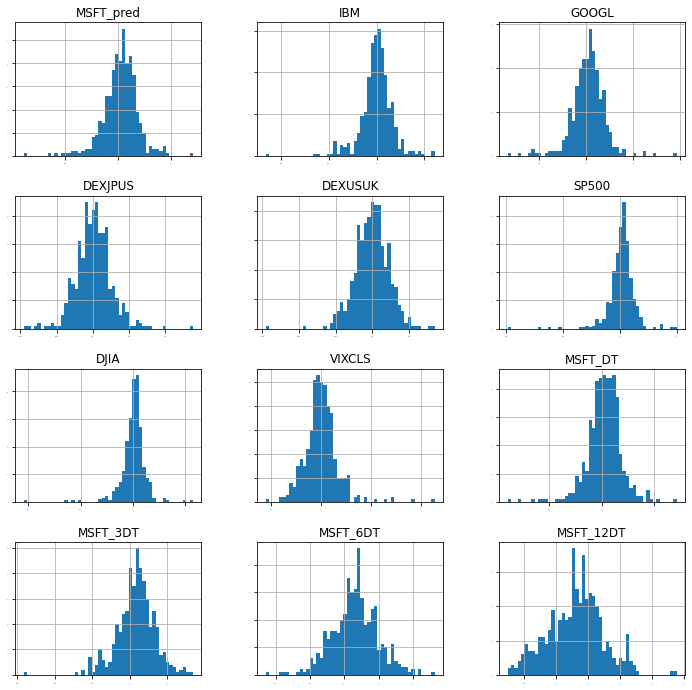

In [15]:
dataset.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()

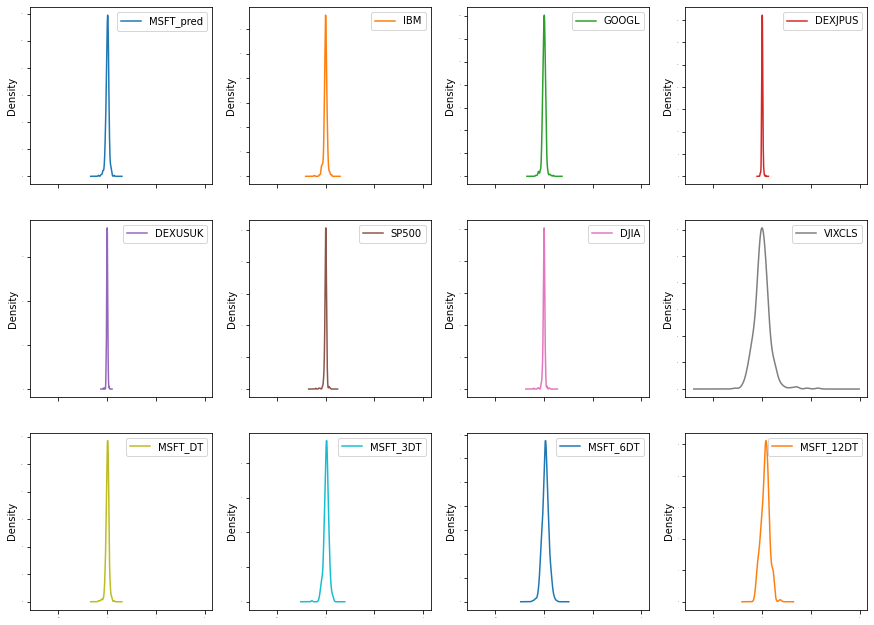

In [16]:
dataset.plot(kind='density', subplots=True, layout=(4,4), sharex=True, legend=True, fontsize=1, figsize=(15,15))
pyplot.show()

VIX parece tener mayor varianza comaprada a las otras distribuciones.

## Correlaciones

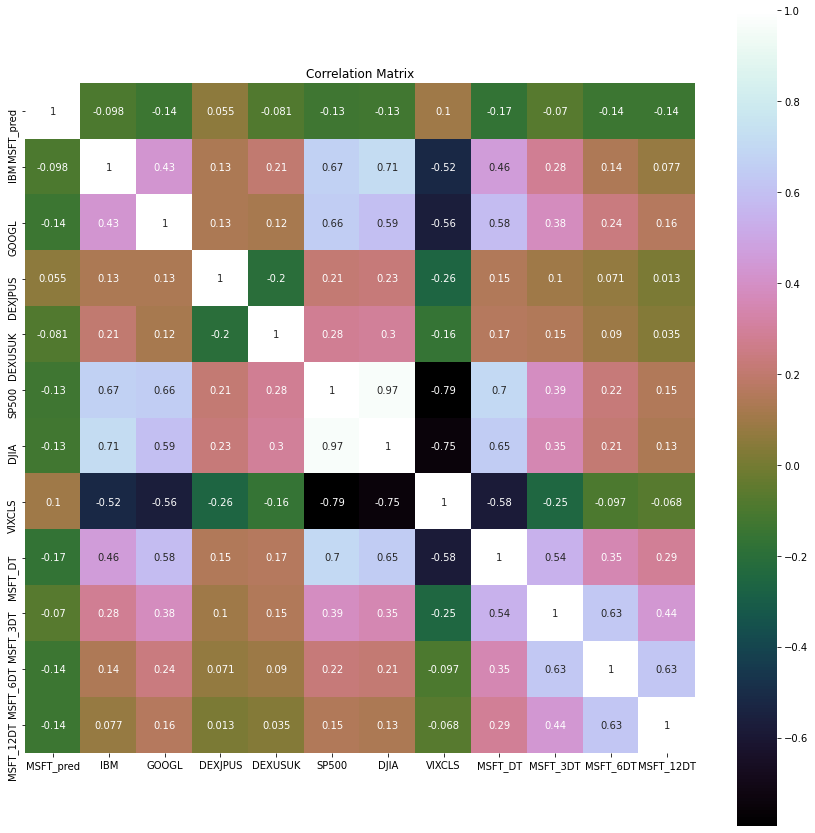

In [17]:
correlation = dataset.corr()
pyplot.figure(figsize=(15,15))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

Vemos que las correlaciones mas altas son respecto a sus variables laggeadas.

# EDA Series de Tiempo

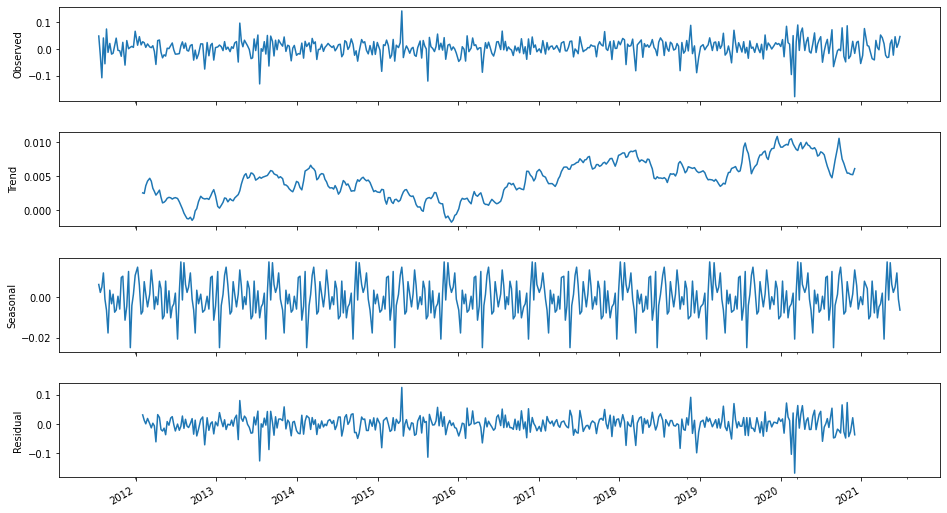

In [18]:
res = sm.tsa.seasonal_decompose(Y,freq=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

Podemos observar que el trend es un poco a la baja o constante en los ultimos dias.

# Feature Selection

Usemos [SelectKBest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html) para seleccionar las mejores variables.

In [19]:
bestfeatures = SelectKBest(k=5, score_func=f_regression)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

# Visualizaciones
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
featureScores.nlargest(10,'Score').set_index('Specs')  #print 10 best features

,Score
Specs,
MSFT_DT,14.121
MSFT_12DT,9.024
GOOGL,8.926
MSFT_6DT,8.864
SP500,8.525
DJIA,7.895
VIXCLS,4.851
IBM,4.588
DEXUSUK,3.123


# Modelos

## Separemos los datos de Manera Adecuada

Dividamos los Datos de Manera Educada!

Ordenemoslos por timestamp (que es le indice).

In [20]:
X = X.sort_index(ascending=True)
X.reset_index(drop=True, inplace=True)
Y = Y.sort_index(ascending=True)
Y.reset_index(drop=True, inplace=True)

In [21]:
n_test = 50

#Test
X_test = X[-n_test:]
Y_test = Y[-n_test:]
# Train
X_train = X[:-n_test]
Y_train = Y[:-n_test]


In [22]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)
print(tscv)
split_idx = []
for train_index, test_index in tscv.split(X_train):
    #print("TRAIN:", train_index, "TEST:", test_index)
    #X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    split_idx.append((train_index, test_index))

TimeSeriesSplit(max_train_size=None, n_splits=5)


In [23]:
split_idx

[(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
         34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
         51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
         68, 69, 70, 71, 72, 73]),
  array([ 74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,
          87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99,
         100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
         113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
         126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
         139, 140, 141, 142, 143])),
 (array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
          13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
          26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
          39,  40,  41,  42,

Originalmente obtuve un warning de que sklearn dejaria de utilisar el `rmse` y pasaria a utilizar `neg_mean_squared_error`

In [24]:
seed = 7
scoring = 'neg_mean_squared_error'

## Modelos Clasicos

**Modelos Estandar**

In [25]:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))
models.append(('MLP', MLPRegressor()))
models.append(('DummyMean', DummyRegressor()))
models.append(('DummyMed', DummyRegressor(strategy='median')))


**Modelos de Boosting y Bagging**

In [26]:
# Boosting 
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging 
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

### K-folds para eleccion de modelos

In [27]:
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)
    
    ## K Fold analysis:
    
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X=X_train, y=Y_train, cv=split_idx, 
                                     scoring=scoring, n_jobs=-1)
    kfold_results.append(cv_results)
    

    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)

    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), 
                                 train_result, test_result)
    print(msg)

LR: 0.001080 (0.000383) 0.000946 0.001336
LASSO: 0.001025 (0.000358) 0.001004 0.001365
EN: 0.001025 (0.000358) 0.001004 0.001365
KNN: 0.001178 (0.000353) 0.000726 0.001339
CART: 0.002231 (0.000578) 0.000000 0.002884
SVR: 0.001449 (0.000380) 0.001672 0.002300
MLP: 0.001803 (0.001089) 0.000990 0.001504
DummyMean: 0.001025 (0.000358) 0.001004 0.001365
DummyMed: 0.001022 (0.000356) 0.001012 0.001367
ABR: 0.001196 (0.000480) 0.000773 0.001355
GBR: 0.001196 (0.000376) 0.000274 0.001483
RFR: 0.001096 (0.000341) 0.000150 0.001384
ETR: 0.001141 (0.000370) 0.000000 0.001319


In [28]:
_mod = Lasso()
_mod.fit(X_train, Y_train)
print(_mod.coef_)
print(_mod.intercept_)

[-0. -0.  0. -0. -0. -0.  0. -0. -0. -0. -0.]
0.004446572425998876


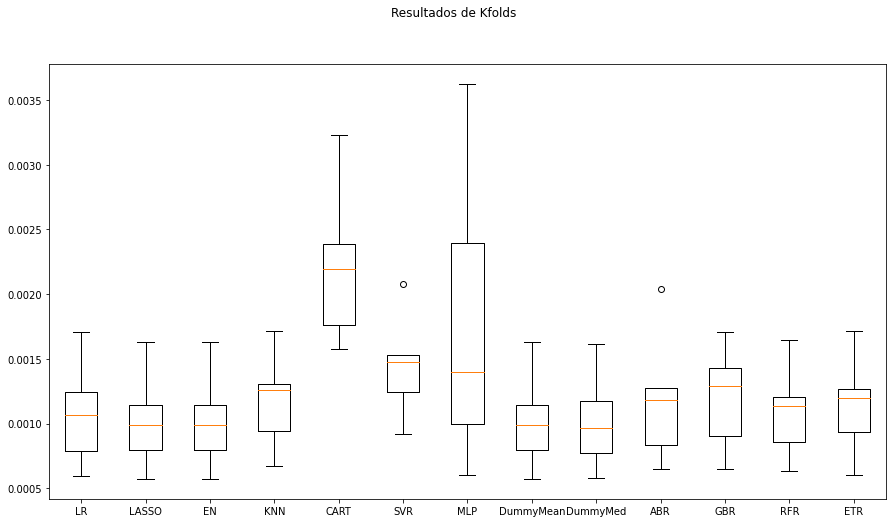

In [29]:
fig = pyplot.figure()
fig.suptitle('Resultados de Kfolds')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

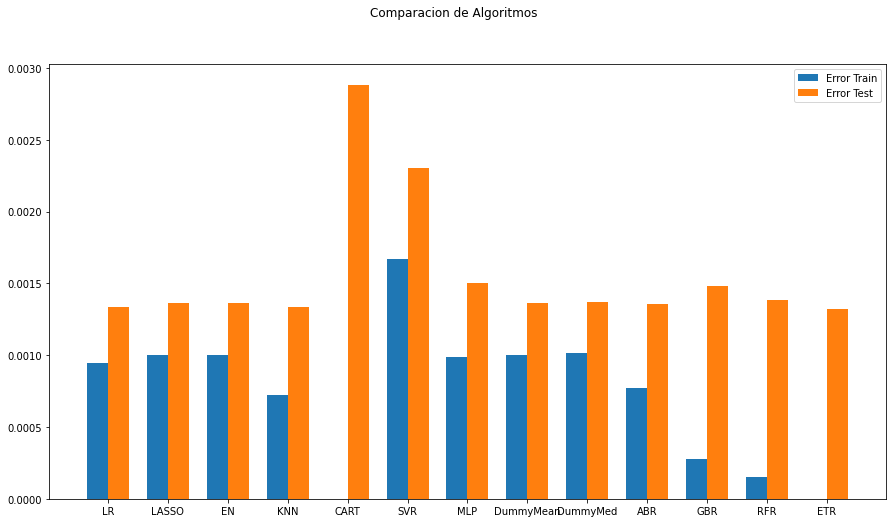

In [30]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Comparacion de Algoritmos')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Error Train')
pyplot.bar(ind + width/2, test_results, width=width, label='Error Test')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

+ Parece que los modelos CART y ETR tiene muy buen performance en el train, pero pesimo en el test.  
+ Los modelos de **ensamble** como GBR y RF tienen **bias pequeño**, pero **varianza alta**

## Modelos de time Series

Documentacion [ARIMA](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html)

Video explicacion de [ARIMA](https://www.youtube.com/watch?v=emF1iBcni0U)

In [31]:
X_train_ARIMA = X_train.loc[:, ['GOOGL', 'IBM', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS']]
X_test_ARIMA = X_test.loc[:, ['GOOGL', 'IBM', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS']]
tr_len = len(X_train_ARIMA)
te_len = len(X_test_ARIMA)
to_len = len (X)

In [32]:
modelARIMA=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=[1,0,0])
model_fit = modelARIMA.fit()

In [33]:
error_Training_ARIMA = mean_squared_error(Y_train, model_fit.fittedvalues)
predicted = model_fit.predict(start = tr_len -1 ,end = to_len -1, exog = X_test_ARIMA)[1:]
error_Test_ARIMA = mean_squared_error(Y_test,predicted)
error_Test_ARIMA

0.0013516792665159737

## Deep Learning: LSTM

In [34]:
#Tamaño de Secuencia de LSTM
seq_len = 2 

Y_train_LSTM, Y_test_LSTM = np.array(Y_train)[seq_len-1:], np.array(Y_test)
X_train_LSTM = np.zeros((X_train.shape[0]+1-seq_len, seq_len, X_train.shape[1]))
X_test_LSTM = np.zeros((X_test.shape[0], seq_len, X.shape[1]))
for i in range(seq_len):
    X_train_LSTM[:, i, :] = np.array(X_train)[i:X_train.shape[0]+i+1-seq_len, :]
    X_test_LSTM[:, i, :] = np.array(X)[X_train.shape[0]+i-1:X.shape[0]+i+1-seq_len, :]

In [35]:
# LSTM Network
def create_LSTMmodel(neurons=12, learn_rate = 0.01, momentum=0):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])))
    #Cells 
    model.add(Dense(1))
    optimizer = SGD(lr=learn_rate, momentum=momentum)
    model.compile(loss='mse', optimizer='adam')
    return model
LSTMModel = create_LSTMmodel(12, learn_rate = 0.01, momentum=0)
LSTMModel_fit = LSTMModel.fit(X_train_LSTM, Y_train_LSTM, validation_data=(X_test_LSTM, Y_test_LSTM),
                              epochs=330, batch_size=72, verbose=0, shuffle=False)

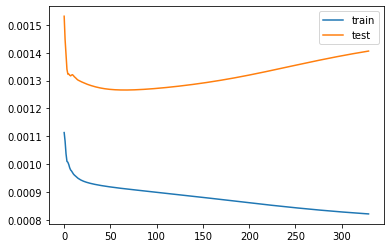

In [36]:
#Visualizacion del Error
pyplot.plot(LSTMModel_fit.history['loss'], label='train')
pyplot.plot(LSTMModel_fit.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [53]:
LSTMModel = create_LSTMmodel(12, learn_rate = 0.01, momentum=0)
LSTMModel_fit = LSTMModel.fit(X_train_LSTM, Y_train_LSTM, validation_data=(X_test_LSTM, Y_test_LSTM),
                              epochs=80, batch_size=72, verbose=0, shuffle=False)

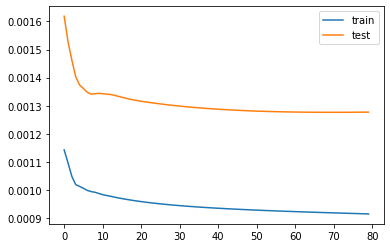

In [54]:
#Visualizacion del error
pyplot.plot(LSTMModel_fit.history['loss'], label='train')
pyplot.plot(LSTMModel_fit.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [55]:
error_Training_LSTM = mean_squared_error(Y_train_LSTM, LSTMModel.predict(X_train_LSTM))
predicted = LSTMModel.predict(X_test_LSTM)
error_Test_LSTM = mean_squared_error(Y_test,predicted)

In [56]:
test_results.append(error_Test_ARIMA)
test_results.append(error_Test_LSTM)

train_results.append(error_Training_ARIMA)
train_results.append(error_Training_LSTM)

names.append("ARIMA")
names.append("LSTM")

## Analisis de Resultados

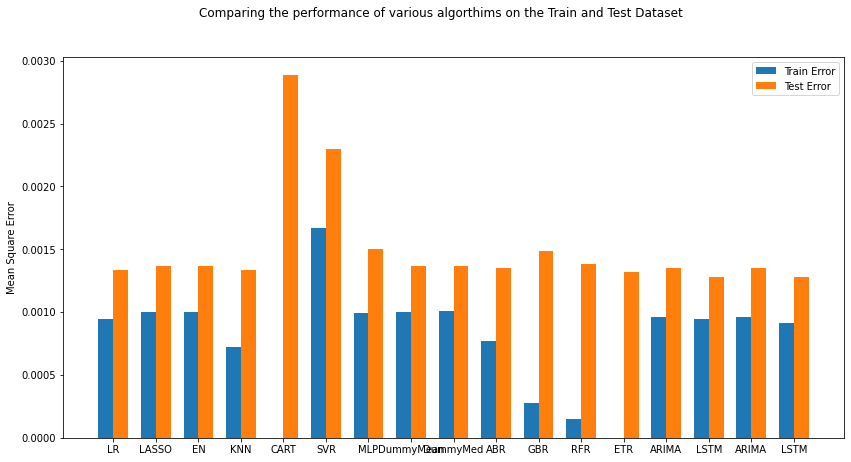

In [57]:
# Comparar Algoritmos
fig = pyplot.figure()

ind = np.arange(len(names))  
width = 0.35  

fig.suptitle('Comparing the performance of various algorthims on the Train and Test Dataset')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(14,7)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.ylabel('Mean Square Error')
pyplot.show()

Parece que los modelos **lineales**, **KNN**, **ARIMA** y **LSTM** tienen el mejor performance en el test y train.  
Para probar algo nuevo, utilizaremos el modelo ARIMA.

# Tuneo de ARIMA

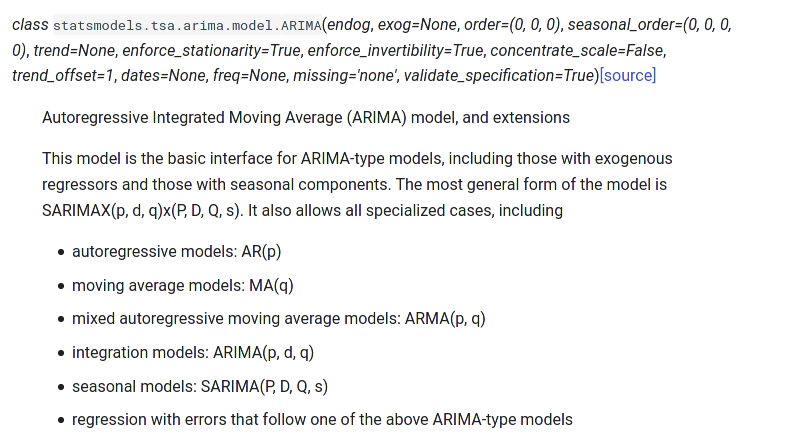

**Tarea**  
Determinar / estudiar / investigar, el significado del parametro `d` en el modelo `ARIMA`.

In [58]:
def evaluate_arima_model(arima_order):
    modelARIMA=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=arima_order)
    model_fit = modelARIMA.fit()
    tr_len = len(X_train_ARIMA)
    te_len = len(X_test_ARIMA)
    to_len = len (X)
    error = mean_squared_error(Y_train, model_fit.fittedvalues)
    predicted = model_fit.predict(start = tr_len -1 ,end = to_len -1, exog = X_test_ARIMA)[1:]
    error_Test_ARIMA = mean_squared_error(Y_test,predicted)
    return error_Test_ARIMA
 
# Evaluar
def evaluate_models(p_values, d_values, q_values): 
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)                
                try:
                    mse = evaluate_arima_model(order)                    
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.7f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.7f' % (best_cfg, best_score))

In [59]:
p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(p_values, d_values, q_values) 

ARIMA(0, 0, 0) MSE=0.0013182
ARIMA(0, 0, 1) MSE=0.0013496
ARIMA(0, 0, 2) MSE=0.0013491
ARIMA(1, 0, 0) MSE=0.0013517
ARIMA(1, 0, 1) MSE=0.0013480
ARIMA(2, 0, 0) MSE=0.0013487
ARIMA(2, 0, 1) MSE=0.0013496
ARIMA(2, 0, 2) MSE=0.0014128
Best ARIMA(0, 0, 0) MSE=0.0013182


# Finalizacion de Arima

In [44]:
modelARIMA_tuned=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=[2,0,1])
model_fit_tuned = modelARIMA_tuned.fit()

In [45]:
predicted_tuned = model_fit.predict(start = tr_len -1 ,end = to_len -1, exog = X_test_ARIMA)[1:]
print(mean_squared_error(Y_test,predicted_tuned))

0.0013516792665159737


## Pickles para Guardar Modelos

[Pickle](https://docs.python.org/3/library/pickle.html)

In [61]:
# Save Model Using Pickle
from pickle import dump
from pickle import load

# save the model to disk
filename = 'finalized_model_test.sav'
dump(model_fit_tuned, open(filename, 'wb'))

In [63]:
# open the file for reading
pickle_in = open("finalized_model_test.sav", "rb")
# load the object from the file into var a
a = load(pickle_in)

print(a)

In [64]:
predicted_tuned = a.predict(start = tr_len -1 ,end = to_len -1, exog = X_test_ARIMA)[1:]
print(mean_squared_error(Y_test,predicted_tuned))

0.0013495714079979763


# Aprendizajes

Observa como no le ganamos a la media o mediana de los modelos Dummies de forma facil,  a pesar de utilizar diferentes modelos. Podriamos incluir:
+ Mas datos
+ Mas Variables: 
+ Otros modelos: Analisis de Sentimientos, Procesamiento del Lenguaje Natural
+ Otros Proyectos: Portafolios de Inversion, Bots